In [1]:
from transformers import BertConfig
from gnn import GNNTrainer
from movie_lens_loader import MovieLensLoader
from llm import PromptBertClassifier, VanillaBertClassifier, AddingEmbeddingsBertClassifierBase, mean_over_ranges

import itertools
import random as rd
from typing import List, Tuple

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
import networkx as nx
from sklearn.decomposition import PCA
import pandas as pd
from scipy.spatial import ConvexHull

In [2]:
config = BertConfig.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
KGE_DIMENSION_PROMPT = 4
KGE_DIMENSION_ADDING = 128
KGE_DIMENSIONS = [KGE_DIMENSION_PROMPT, KGE_DIMENSION_ADDING] # Output Dimension of the GNN Encoder.
model_max_length_vanilla_and_embedding = 256
model_max_length_prompt = 512
movie_lens_loader = MovieLensLoader(kge_dimensions = KGE_DIMENSIONS)
gnn_trainer_prompt =    GNNTrainer(movie_lens_loader.data, kge_dimension = KGE_DIMENSION_PROMPT)
gnn_trainer_prompt.get_embeddings(movie_lens_loader)
gnn_trainer_adding =    GNNTrainer(movie_lens_loader.data, hidden_channels=KGE_DIMENSION_ADDING, kge_dimension = KGE_DIMENSION_ADDING)
gnn_trainer_adding.get_embeddings(movie_lens_loader)
vanilla_bert_only_classifier = VanillaBertClassifier(movie_lens_loader.llm_df,model_max_length = model_max_length_vanilla_and_embedding)
dataset_vanilla = movie_lens_loader.generate_vanilla_dataset(vanilla_bert_only_classifier.tokenize_function)
prompt_bert_only_classifier = PromptBertClassifier(movie_lens_loader, gnn_trainer_prompt.get_embedding, kge_dimension=gnn_trainer_prompt.kge_dimension,model_max_length = model_max_length_prompt)
dataset_prompt = movie_lens_loader.generate_prompt_embedding_dataset(prompt_bert_only_classifier.tokenize_function, kge_dimension = prompt_bert_only_classifier.kge_dimension)
adding_embedding_bert_only_classifier = AddingEmbeddingsBertClassifierBase(movie_lens_loader, gnn_trainer_adding.get_embedding, kge_dimension=config.hidden_size,model_max_length = model_max_length_vanilla_and_embedding)
dataset_adding_embedding = movie_lens_loader.generate_adding_embedding_dataset(adding_embedding_bert_only_classifier.tokenizer.sep_token, adding_embedding_bert_only_classifier.tokenizer.pad_token, adding_embedding_bert_only_classifier.tokenize_function, kge_dimension = config.hidden_size)

loading pretrained model
Device: 'cpu'
loading pretrained model
Device: 'cpu'


In [3]:
vanilla_hidden_states_df = vanilla_bert_only_classifier.forward_dataset_and_save_outputs(dataset_vanilla)
prompt_hidden_states_df = prompt_bert_only_classifier.forward_dataset_and_save_outputs(dataset_prompt)
adding_embedding_hidden_states_df = adding_embedding_bert_only_classifier.forward_dataset_and_save_outputs(dataset_adding_embedding)

In [4]:
vanilla_hidden_states = torch.stack(vanilla_hidden_states_df[vanilla_hidden_states_df["split"] == "train"]["hidden_states"].tolist())
prompt_hidden_states = torch.stack(prompt_hidden_states_df[prompt_hidden_states_df["split"] == "train"]["hidden_states"].tolist())
adding_embedding_hidden_states = torch.stack(adding_embedding_hidden_states_df[adding_embedding_hidden_states_df["split"] == "train"]["hidden_states"].tolist())

In [5]:
vanilla_pcas = vanilla_bert_only_classifier.init_pca(vanilla_hidden_states)
prompt_pcas = prompt_bert_only_classifier.init_pca(prompt_hidden_states)
adding_embedding_pcas = adding_embedding_bert_only_classifier.init_pca(adding_embedding_hidden_states)

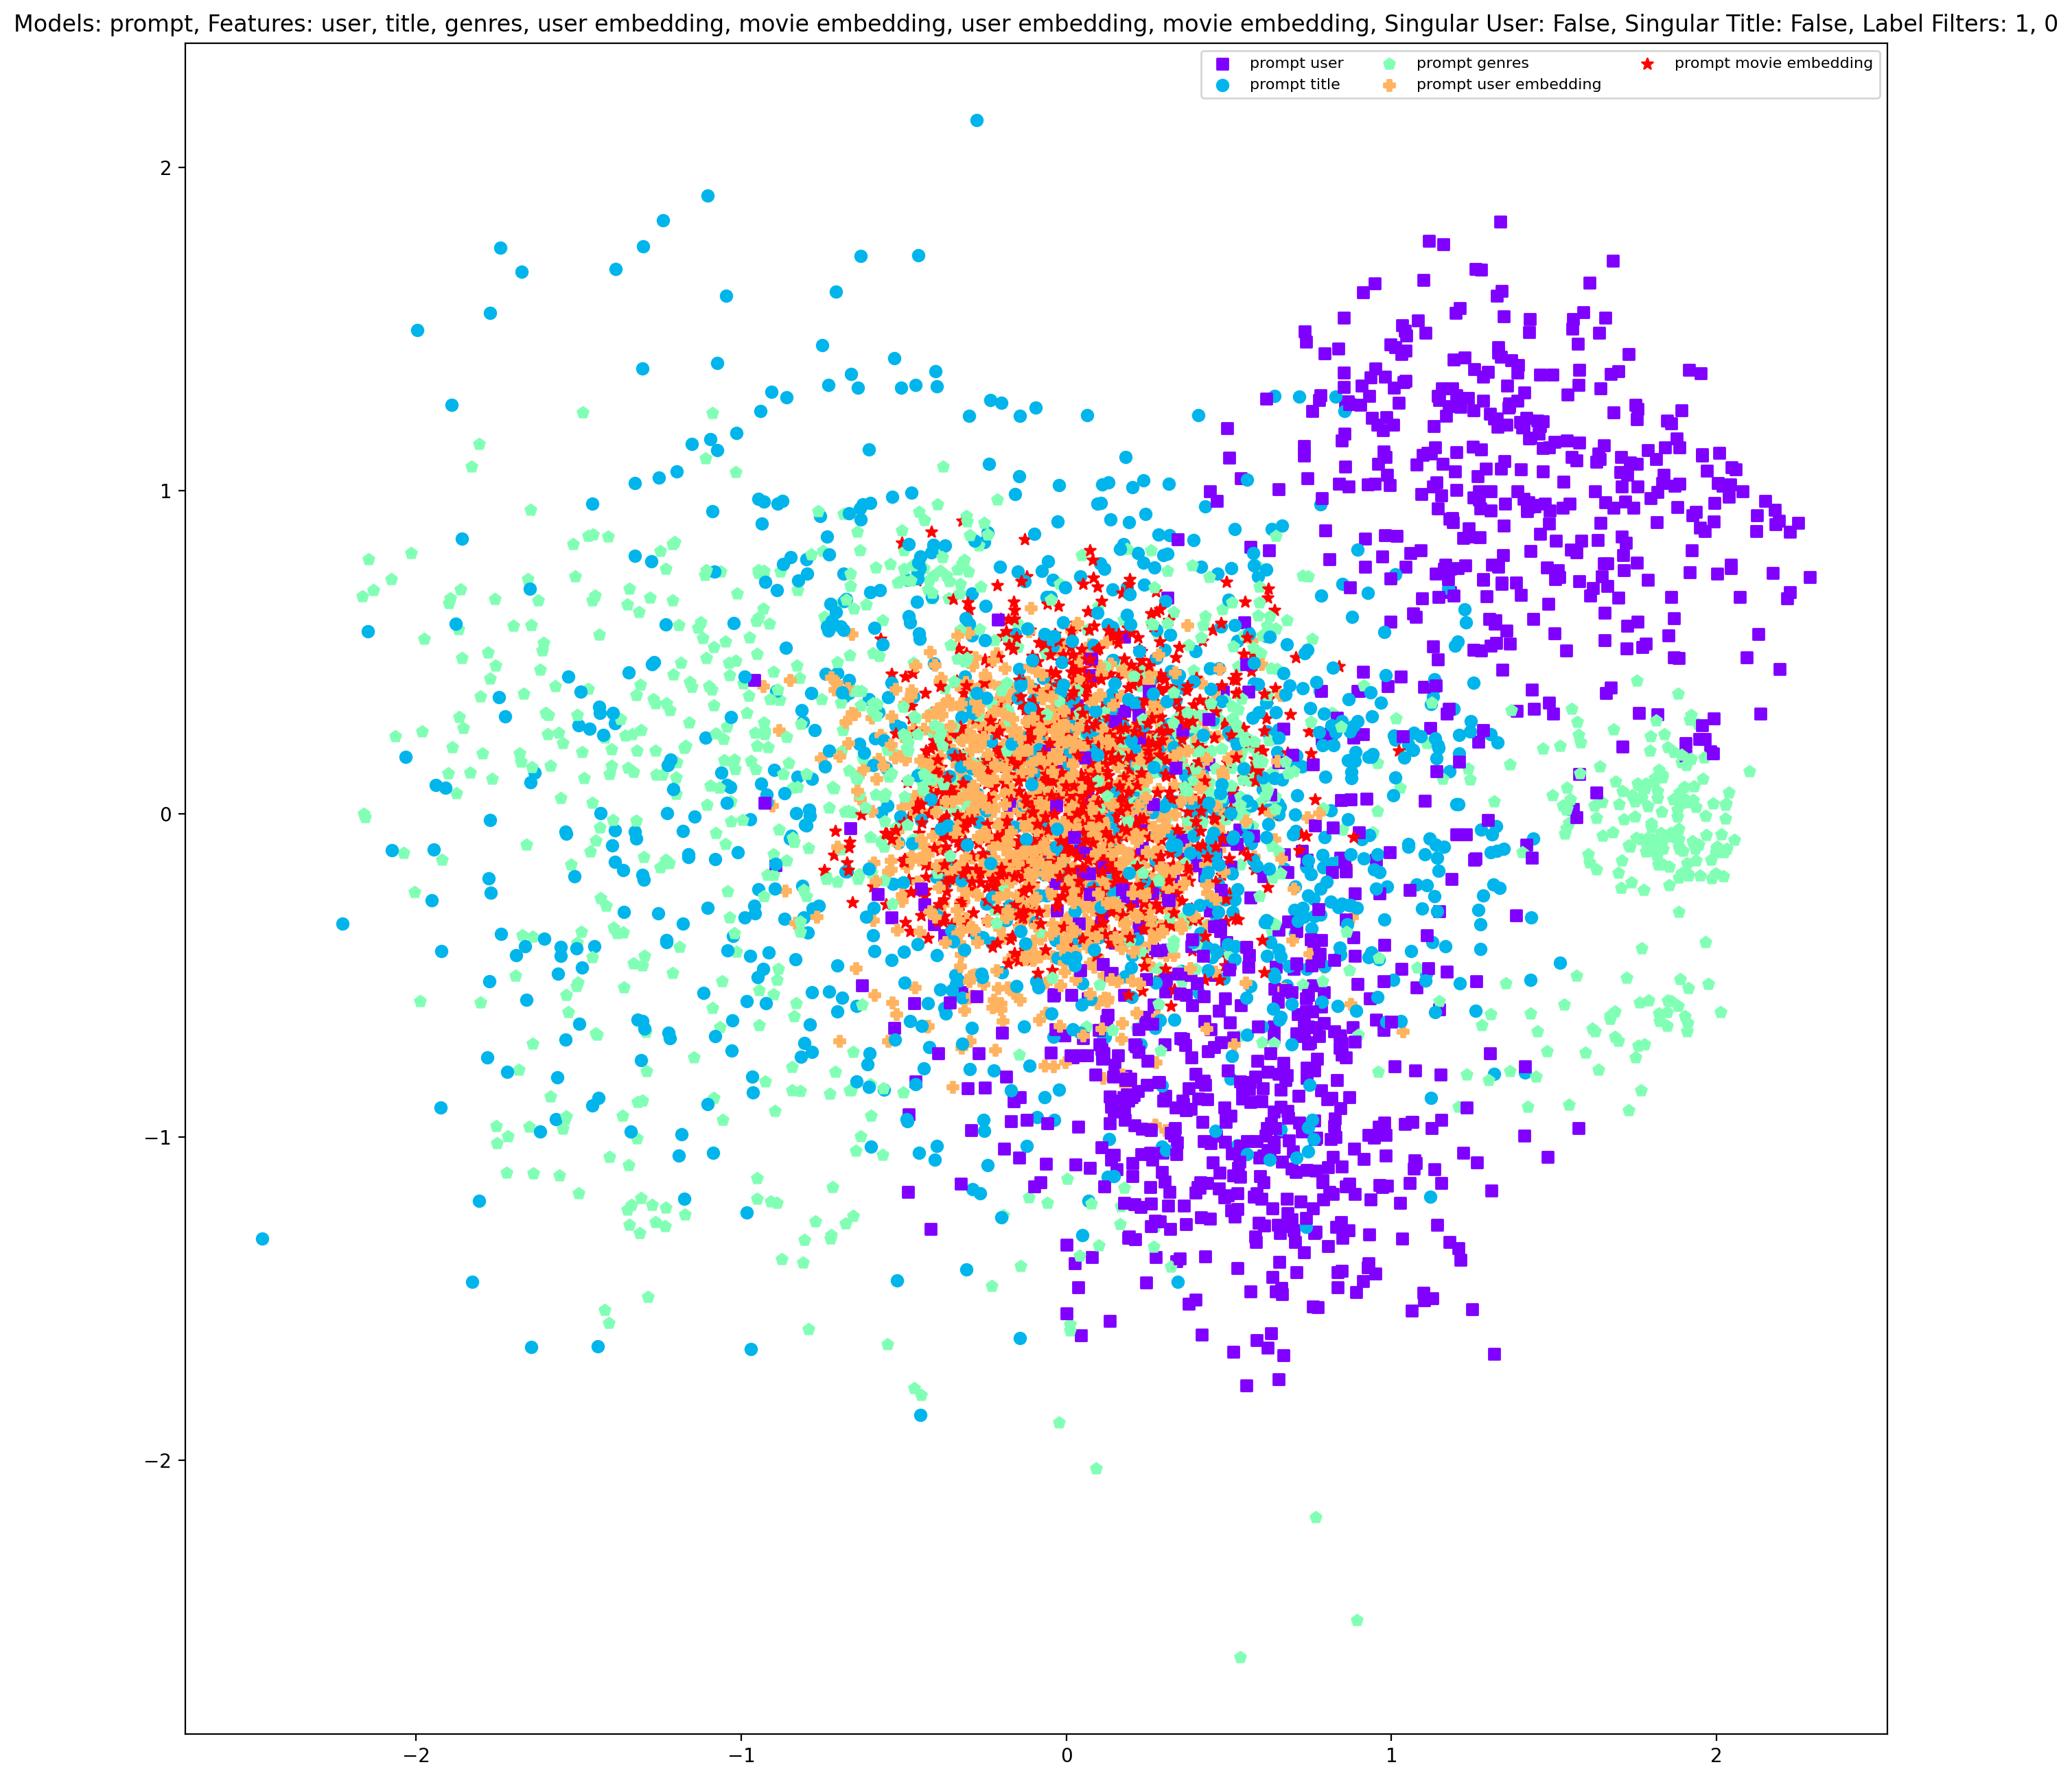

<Figure size 800x800 with 0 Axes>

In [18]:
def nearest_neighbor(point, points):
    distances = np.linalg.norm(points - point, axis=1)
    return np.argmin(distances)

def filter_by_singular_user(vanilla_df:pd.DataFrame, prompt_df:pd.DataFrame, embedding_df:pd.DataFrame, min_size = 25) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    vanilla_count = vanilla_df['user_id'].value_counts().rename('vanilla_count')
    prompt_count = prompt_df['user_id'].value_counts().rename('prompt_count')
    embedding_count = embedding_df['user_id'].value_counts().rename('embedding_count')
    combined_counts = pd.concat([vanilla_count, prompt_count, embedding_count], axis=1).fillna(0).astype(int).reset_index()
    combined_counts = combined_counts[(combined_counts["vanilla_count"] >= min_size) & (combined_counts["prompt_count"] >= min_size) & (combined_counts["embedding_count"] >= min_size)]
    if not len(combined_counts) > 0:
        raise Exception("There are not enough user_ids matching over all models.")
    singular_user = rd.choice(combined_counts["user_id"].unique())
    return vanilla_df[vanilla_df["user_id"] == singular_user], prompt_df[prompt_df["user_id"] == singular_user], embedding_df[embedding_df["user_id"] == singular_user]

def filter_by_singular_title(vanilla_df:pd.DataFrame, prompt_df:pd.DataFrame, embedding_df:pd.DataFrame, min_size = 25) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    vanilla_count = vanilla_df['title'].value_counts().rename('vanilla_count')
    prompt_count = prompt_df['title'].value_counts().rename('prompt_count')
    embedding_count = embedding_df['title'].value_counts().rename('embedding_count')
    combined_counts = pd.concat([vanilla_count, prompt_count, embedding_count], axis=1).fillna(0).astype(int).reset_index()
    combined_counts = combined_counts[(combined_counts["vanilla_count"] >= min_size) & (combined_counts["prompt_count"] >= min_size) & (combined_counts["embedding_count"] >= min_size)]
    if not len(combined_counts) > 0:
        raise Exception("There are not enough titles matching over all models.")
    singular_title = rd.choice(combined_counts["title"].unique())
    return vanilla_df[vanilla_df["title"] == singular_title], prompt_df[prompt_df["title"] == singular_title], embedding_df[embedding_df["title"] == singular_title]

def plot_hidden_states_with_pca(vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df, vanilla_pcas, prompt_pcas, embedding_pcas, add_edges = "None", n = 1, model_filters = ['vanilla', "prompt", "embedding"], feature_filters = ['user', 'title', 'genres', 'user embedding', 'movie embedding'], label_filters = [1, 0], singular_user = False, singular_title = False, figure_dpi = 100, fig_size = (8,8)):
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['figure.dpi'] = figure_dpi # 200 e.g. is really fine, but slower
    vanilla_hidden_states_df = vanilla_hidden_states_df[vanilla_hidden_states_df["labels"].isin(label_filters)]
    prompt_hidden_states_df = prompt_hidden_states_df[prompt_hidden_states_df["labels"].isin(label_filters)]
    embedding_hidden_states_df = embedding_hidden_states_df[embedding_hidden_states_df["labels"].isin(label_filters)]
    if singular_user:
        vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df = filter_by_singular_user(vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df, min_size=n)
    if singular_title:
        vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df = filter_by_singular_title(vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df, min_size=n)
    vanilla_hidden_states_df = vanilla_hidden_states_df.sample(n=n)
    prompt_hidden_states_df = prompt_hidden_states_df.sample(n=n)
    embedding_hidden_states_df = embedding_hidden_states_df.sample(n=n)


    vanilla_hidden_states = torch.stack(vanilla_hidden_states_df["hidden_states"].tolist()).permute(1,0,2)
    prompt_hidden_states = torch.stack(prompt_hidden_states_df["hidden_states"].tolist()).permute(1,0,2)
    embedding_hidden_states = torch.stack(embedding_hidden_states_df["hidden_states"].tolist()).permute(1,0,2)
    low_dim_reps_vanilla = []
    for pca, last_hidden_states in zip(vanilla_pcas, vanilla_hidden_states):
        low_dim_rep = pca.transform(last_hidden_states)
        low_dim_reps_vanilla.append(low_dim_rep)
    
    low_dim_reps_prompt = []
    for pca, last_hidden_states in zip(prompt_pcas, prompt_hidden_states):
        low_dim_rep = pca.transform(last_hidden_states)
        low_dim_reps_prompt.append(low_dim_rep)
    
    low_dim_reps_embedding = []
    for pca, last_hidden_states in zip(embedding_pcas, embedding_hidden_states):
        low_dim_rep = pca.transform(last_hidden_states)
        low_dim_reps_embedding.append(low_dim_rep)
    
    low_dim_reps_vanilla = np.stack(low_dim_reps_vanilla).transpose((1,0,2))
    low_dim_reps_prompt = np.stack(low_dim_reps_prompt).transpose((1,0,2))
    low_dim_reps_embedding = np.stack(low_dim_reps_embedding).transpose((1,0,2))

        
    colors = cm.rainbow(np.linspace(0, 1, 5))
    for low_dim_reps_vanilla_, low_dim_reps_prompt_, low_dim_reps_embedding_ in zip(low_dim_reps_vanilla,low_dim_reps_prompt, low_dim_reps_embedding):
        user_id_embedding_vanilla = low_dim_reps_vanilla_[0]
        title_embedding_vanilla = low_dim_reps_vanilla_[1]
        genres_embedding_vanilla = low_dim_reps_vanilla_[2]

        scatter_legend = []
        if "vanilla" in model_filters:
            if "user" in feature_filters:
                v_u = plt.scatter([user_id_embedding_vanilla[0]], [user_id_embedding_vanilla[1]], marker="<", color = colors[0])
                scatter_legend.append(v_u)
            if "title" in feature_filters:
                v_t = plt.scatter([title_embedding_vanilla[0]], [title_embedding_vanilla[1]], marker="v", color = colors[1])
                scatter_legend.append(v_t)
            if "genres" in feature_filters:
                v_g = plt.scatter([genres_embedding_vanilla[0]], [genres_embedding_vanilla[1]], marker=">", color = colors[2])
                scatter_legend.append(v_g)

        if "prompt" in model_filters:
            user_id_embedding_prompt = low_dim_reps_prompt_[0]
            title_embedding_prompt = low_dim_reps_prompt_[1]
            genres_embedding_prompt = low_dim_reps_prompt_[2]
            user_embedding_embedding_prompt = low_dim_reps_prompt_[3]
            movie_embedding_embedding_prompt = low_dim_reps_prompt_[4]
            if "user" in feature_filters:
                p_u = plt.scatter([user_id_embedding_prompt[0]], [user_id_embedding_prompt[1]], marker="s", color = colors[0])
                scatter_legend.append(p_u)
            if "title" in feature_filters:
                p_t = plt.scatter([title_embedding_prompt[0]], [title_embedding_prompt[1]], marker="o", color = colors[1])
                scatter_legend.append(p_t)
            if "genres" in feature_filters:
                p_g = plt.scatter([genres_embedding_prompt[0]], [genres_embedding_prompt[1]], marker="p", color = colors[2])
                scatter_legend.append(p_g)
            if "user embedding" in feature_filters:
                p_ue = plt.scatter([user_embedding_embedding_prompt[0]], [user_embedding_embedding_prompt[1]], marker="P", color = colors[3])
                scatter_legend.append(p_ue)
            if "movie embedding" in feature_filters:
                p_me = plt.scatter([movie_embedding_embedding_prompt[0]], [movie_embedding_embedding_prompt[1]], marker="*", color = colors[4])
                scatter_legend.append(p_me)
        
        if "embedding" in model_filters:
            user_id_embedding_embedding = low_dim_reps_embedding_[0]
            title_embedding_embedding = low_dim_reps_embedding_[1]
            genres_embedding_embedding = low_dim_reps_embedding_[2]
            user_embedding_embedding_embedding = low_dim_reps_embedding_[3]
            movie_embedding_embedding_embedding = low_dim_reps_embedding_[4]
            if "user" in feature_filters:
                e_u = plt.scatter([user_id_embedding_embedding[0]], [user_id_embedding_embedding[1]], marker="1", color = colors[0])
                scatter_legend.append(e_u)
            if "title" in feature_filters:
                e_t = plt.scatter([title_embedding_embedding[0]], [title_embedding_embedding[1]], marker="2", color = colors[1])
                scatter_legend.append(e_t)
            if "genres" in feature_filters:
                e_g = plt.scatter([genres_embedding_embedding[0]], [genres_embedding_embedding[1]], marker="3", color = colors[2])
                scatter_legend.append(e_g)
            if "user embedding" in feature_filters:
                e_ue = plt.scatter([user_embedding_embedding_embedding[0]], [user_embedding_embedding_embedding[1]], marker="4", color = colors[3])
                scatter_legend.append(e_ue)
            if "movie embedding" in feature_filters:
                e_me = plt.scatter([movie_embedding_embedding_embedding[0]], [movie_embedding_embedding_embedding[1]], marker="x", color = colors[4])
                scatter_legend.append(e_me)

        if add_edges != "None":
            for model_name, points in zip(["vanilla", "prompt", "embedding"], [low_dim_reps_vanilla_, low_dim_reps_prompt_, low_dim_reps_embedding_]):
                if model_name in model_filters:
                    if add_edges == "Planar":
                        # Compute the Convex Hull
                        hull = ConvexHull(points)

                        # Get the vertices of the convex hull
                        hull_indices = hull.vertices
                        hull_points = points[hull_indices]

                        # Sort the remaining points (not in the convex hull) by nearest neighbor
                        remaining_indices = [i for i in range(len(points)) if i not in hull_indices]

                        if remaining_indices:
                            sorted_remaining_indices = []
                            current_index = remaining_indices[0]
                            sorted_remaining_indices.append(current_index)
                            remaining_indices.remove(current_index)

                            while remaining_indices:
                                next_index = nearest_neighbor(points[current_index], points[remaining_indices])
                                current_index = remaining_indices[next_index]
                                sorted_remaining_indices.append(current_index)
                                remaining_indices.remove(current_index)

                            # Combine hull points and sorted inner points
                            sorted_indices = list(hull_indices) + sorted_remaining_indices
                        else:
                            # If no remaining points, just use the hull points
                            sorted_indices = list(hull_indices)

                        # Close the loop by returning to the first point
                        sorted_indices.append(sorted_indices[0])
                        sorted_points = points[sorted_indices]
                    #for idx, token_x in enumerate(["user", "title", "genres", "user embedding", "movie embedding"]):
                    plt.plot(sorted_points[:,0], sorted_points[:,1], linestyle='-', color='black', linewidth=0.5)
    plot_filters = []
    for model in model_filters:
        for feature in feature_filters:
            plot_filters.append(f"{model} {feature}")
    plt.legend(scatter_legend,
            plot_filters,
            scatterpoints=1,
            loc='upper right',
            ncol=3,
            fontsize=8,)
    label_filters = [str(label_filter) for label_filter in label_filters]
    title = f"Models: {", ".join(model_filters)}, Features: {", ".join(feature_filters)}, Singular User: {singular_user}, Singular Title: {singular_title}, Label Filters: {", ".join(label_filters)}"
    plt.title(title)
    plt.figure(figsize=(8, 8), dpi=100)
    plt.show()

only_user_filters = ['user']
only_title_filters = ['title']
only_genres_filters = ['genres']
user_title_filters = ['user', 'title']
embedding_filters = ['user embedding', 'movie embedding', 'user embedding', 'movie embedding']
non_embedding_filters =  ['user', 'title', 'genres']
all_features_filters = ['user', 'title', 'genres', 'user embedding', 'movie embedding', 'user embedding', 'movie embedding']
vanilla_filters = ['vanilla']
prompt_filters = ['prompt']
embedding_filters = ['embedding']
all_models_filters = ['vanilla', 'prompt', 'embedding']
true_filter = [1]
false_filter = [0]
true_false_filter = [1, 0]

n = 1000
feature_filters = all_features_filters
model_filters = prompt_filters
singular_user = False
singular_title = False
label_filters = true_false_filter
add_edges = "None" # , None, Planar
fig_size = (16,16)
fig_dpi = 200
plot_hidden_states_with_pca(vanilla_hidden_states_df, prompt_hidden_states_df, adding_embedding_hidden_states_df, vanilla_pcas, prompt_pcas, adding_embedding_pcas, add_edges = add_edges, n = n, model_filters = model_filters, feature_filters = feature_filters, label_filters = label_filters, singular_user=singular_user, singular_title=singular_title, fig_size=fig_size, figure_dpi=fig_dpi)